# Bandit Optimization

In this notebook we use `boax` to run a Multi-Arm Bandit experiment.

In [1]:
from functools import partial

from jax import jit, lax, random
from jax import numpy as jnp

import matplotlib.pyplot as plt
plt.style.use('bmh')

from boax.optimization import policies
from boax.optimization.policies import evaluators

In [2]:
SEED = 42
NUM_VISITS = 10_000
CLICK_RATES = [0.042, 0.03, 0.035, 0.038, 0.045]

In [3]:
def visit(params, timestep, key, click_rates, policy, evaluator):
    policy_key, user_key = random.split(random.fold_in(key, timestep))

    variant = policy(params, timestep, policy_key)

    clicked = random.uniform(user_key) < click_rates[variant]

    next_params = evaluator.update(params, variant, clicked)

    return next_params, clicked

In [4]:
def evaluate(policy, evaluator):
    return lax.scan(
        jit(
            partial(
                visit,
                key=random.key(SEED),
                click_rates=jnp.array(CLICK_RATES),
                policy=policy,
                evaluator=evaluator,
            )
        ),
        evaluator.init(),
        jnp.arange(1, NUM_VISITS + 1),
    )

In [5]:
def regret(history):
    def accumulate(acc, reward):
        n, v = acc[0] + 1, acc[1] + reward
        return (n, v), 0.045 - (v / n)
    
    _, result = lax.scan(
        jit(accumulate),
        (jnp.array(0), jnp.array(0)),
        history,
    )

    return result

In [6]:
(epsilon_greedy_params, _), epsilon_greedy_history = evaluate(
    policies.epsilon_greedy(0.1),
    evaluators.action_value(len(CLICK_RATES)),
)

In [7]:
(boltzmann_params, _), boltzmann_history = evaluate(
    policies.boltzmann(1.0),
    evaluators.action_value(len(CLICK_RATES)),
)

In [8]:
(ucb_params, _), ucb_history = evaluate(
    policies.upper_confidence_bound(2.0),
    evaluators.action_value(len(CLICK_RATES)),
)

In [9]:
(ts_params, _), ts_history = evaluate(
    policies.thompson_sampling(),
    evaluators.beta(len(CLICK_RATES)),
)

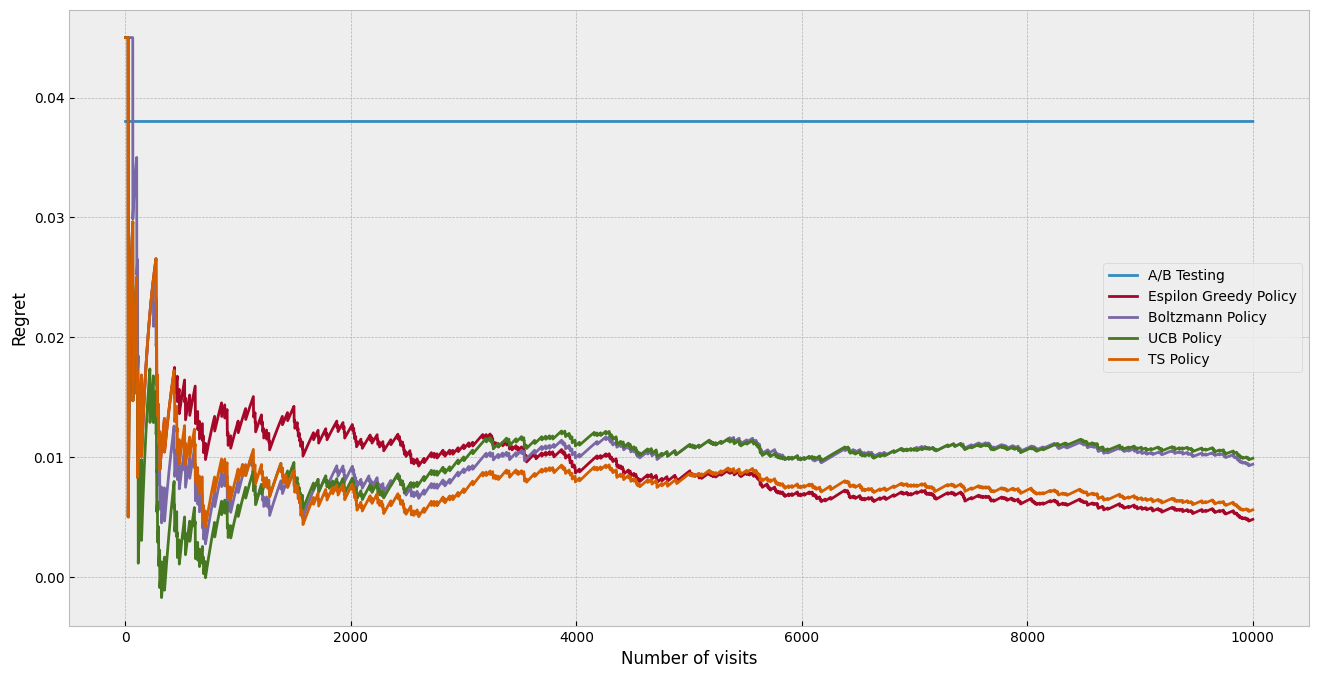

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

x = jnp.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of visits')
ax.set_ylabel('Regret')

ax.plot(x, jnp.repeat(jnp.mean(jnp.array(CLICK_RATES)), NUM_VISITS), label='A/B Testing')
ax.plot(x, regret(epsilon_greedy_history), label='Espilon Greedy Policy')
ax.plot(x, regret(boltzmann_history), label='Boltzmann Policy')
ax.plot(x, regret(ucb_history), label='UCB Policy')
ax.plot(x, regret(ts_history), label='TS Policy')

plt.legend()
plt.show()